
# Neighbors Functional Regression

Shows the usage of the nearest neighbors regressor with functional response. Based on https://fda.readthedocs.io/en/stable/auto_examples/plot_neighbors_functional_regression.html. Implemented to CIMIS weather data by Tom Kovalcik, Paul Ng, and Kateryna Malneva.


In [644]:
# Author: Pablo Marcos Manchón
# License: MIT

# sphinx_gallery_thumbnail_number = 4

from sklearn.model_selection import train_test_split

import datetime
import glob
import pandas as pd
import numpy as np
import skfda
from skfda import FDataGrid
from skfda.ml.regression import KNeighborsRegressor
from skfda.representation.basis import FourierBasis

In this example we are going to show the usage of the nearest neighbors
regressors with functional response. There is available a K-nn version,
:class:`~skfda.ml.regression.KNeighborsRegressor`, and other one based in
the radius, :class:`~skfda.ml.regression.RadiusNeighborsRegressor`.


As in the `scalar response example
<sphx_glr_auto_examples_plot_neighbors_scalar_regression.py>`, we will fetch
the Canadian weather dataset, which contains the daily temperature and
precipitation at 35 different locations in Canada averaged over 1960 to 1994.
The following figure shows the different temperature and precipitation
curves.



In [645]:
files = sorted(glob.glob("data/*.csv"))
df_list = []

# --- Collect start/end dates for each file ---
date_ranges = []   # we'll fill this with dicts per file

for file in files:
    df = pd.read_csv(file, usecols=['Date', 'Precip (in)', 'Avg Air Temp (F)'])
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # handle messy dates
    df = df.sort_values('Date').dropna(subset=['Date'])       # ensure sorted clean dates

    start_date = df['Date'].min()
    end_date   = df['Date'].max()
    n_rows     = len(df)

    date_ranges.append({
        'file': file.split('/')[-1],
        'start_date': start_date,
        'end_date': end_date,
        'n_days': n_rows
    })
    # print(df.shape)

    df_list.append(df)
    # print(dfs)

# Convert to DataFrame for easy viewing
coverage_df = pd.DataFrame(date_ranges)

print(files)
# print(len(df_list))
# df_list
print(coverage_df)#date_ranges

['data/Atascadero_daily_weather.csv', 'data/Auburn_daily_weather.csv', 'data/Bishop_daily_weather.csv', 'data/Davis_daily_weather.csv', 'data/FairOaks_daily_weather.csv', 'data/Ferndale_daily_weather.csv', 'data/Highland_daily_weather.csv', 'data/Irvine_daily_weather.csv', 'data/LagunaSeca_daily_weather.csv', 'data/Lancaster_daily_weather.csv', 'data/LongBeach_daily_weather.csv', 'data/Oakland_daily_weather.csv', 'data/SalinasNorth_daily_weather.csv', 'data/SanelValley_daily_weather.csv', 'data/SantaMonica_daily_weather.csv', 'data/SantaRosa_daily_weather.csv', 'data/TorreyPines_daily_weather.csv', 'data/UnionCity_daily_weather.csv', 'data/Windsor_daily_weather.csv']
                              file start_date   end_date  n_days
0     Atascadero_daily_weather.csv 2020-01-01 2024-12-31    1827
1         Auburn_daily_weather.csv 2020-01-01 2025-10-08    2108
2         Bishop_daily_weather.csv 2020-01-01 2024-12-31    1827
3          Davis_daily_weather.csv 2020-01-01 2025-10-08    2108

In [646]:
# print(max(coverage_df['start_date']))
latest_start_date = max(coverage_df['start_date'])
print(latest_start_date)
if latest_start_date.month == 1 and latest_start_date.day == 1:
    data_start_date = latest_start_date
else:
    data_start_date = pd.Timestamp(latest_start_date.year + 1, 1, 1)
print(data_start_date)

earliest_end_date = min(coverage_df['end_date'])
print(earliest_end_date)
if earliest_end_date.month == 12 and earliest_end_date.day == 31:
    data_end_date = earliest_end_date
else:
    data_end_date = pd.Timestamp(earliest_end_date.year - 1, 12, 31)
print(data_end_date)

2020-01-01 00:00:00
2020-01-01 00:00:00
2024-12-31 00:00:00
2024-12-31 00:00:00


In [647]:
data_end_date
data_start_date

Timestamp('2020-01-01 00:00:00')

In [648]:
import pandas as pd
import numpy as np

# your window
full_index = pd.date_range(start=data_start_date, end=data_end_date, freq='D')

report = []
missing_by_df = []

for i, df in enumerate(df_list):
    d = df.copy()
    d['Date'] = pd.to_datetime(d['Date'])
    d = d.sort_values('Date')

    # If there are duplicate dates, collapse them (keep first) so the diff logic is correct
    d = d.drop_duplicates(subset='Date', keep='first')

    # which dates are missing?
    missing = full_index.difference(d['Date'])
    missing_by_df.append(missing)

    report.append({
        "df_idx": i,
        "rows": len(d),
        "min_date": d['Date'].min(),
        "max_date": d['Date'].max(),
        "n_missing": len(missing)
    })

# Quick summary
summary = pd.DataFrame(report)
print(summary)
# Inspect the exact missing dates for the problematic one(s), e.g. df 0
for i, missing in enumerate(missing_by_df):
    if len(missing) > 0:
        print(f"\nDF {i} missing {len(missing)} dates:")
        print(list(missing))

    df_idx  rows   min_date   max_date  n_missing
0        0  1827 2020-01-01 2024-12-31          0
1        1  2108 2020-01-01 2025-10-08          0
2        2  1827 2020-01-01 2024-12-31          0
3        3  2108 2020-01-01 2025-10-08          0
4        4  2108 2020-01-01 2025-10-08          0
5        5  2255 2019-08-05 2025-10-08          2
6        6  2107 2020-01-01 2025-10-08          1
7        7  3653 2015-10-09 2025-10-08          0
8        8  2107 2020-01-01 2025-10-08          1
9        9  2107 2020-01-01 2025-10-08          1
10      10  2108 2020-01-01 2025-10-08          0
11      11  2772 2018-03-06 2025-10-08          2
12      12  2108 2020-01-01 2025-10-08          0
13      13  2108 2020-01-01 2025-10-08          0
14      14  2108 2020-01-01 2025-10-08          0
15      15  2108 2020-01-01 2025-10-08          0
16      16  1827 2020-01-01 2024-12-31          0
17      17  2108 2020-01-01 2025-10-08          0
18      18  2108 2020-01-01 2025-10-08          0


In [649]:
cols = ['Precip (in)', 'Avg Air Temp (F)']

fixed_df_list = []
for df in df_list:
    d = df.copy()
    d['Date'] = pd.to_datetime(d['Date'])
    # print(d['Date'])
    d = d.drop_duplicates(subset='Date', keep='first').set_index('Date').sort_index()

    # Reindex to the full daily grid → introduces NaNs on missing dates
    d = d.reindex(full_index)

    # Interpolate (avg of prev/next day). Keep ends sensible with ffill/bfill.
    for c in cols:
        d[c] = d[c].interpolate('linear', limit_direction='both')
    d = d.fillna(method='ffill').fillna(method='bfill')

    fixed_df_list.append(d.reset_index().rename(columns={'index': 'Date'}))

df_list = fixed_df_list

# sanity check
print([len(df) for df in df_list])  # should all be 1827

[1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827, 1827]


/var/folders/8q/48hstyms4z79cf6rxhybh5340000gn/T/ipykernel_11045/2240534721.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method='ffill').fillna(method='bfill')
/var/folders/8q/48hstyms4z79cf6rxhybh5340000gn/T/ipykernel_11045/2240534721.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method='ffill').fillna(method='bfill')
/var/folders/8q/48hstyms4z79cf6rxhybh5340000gn/T/ipykernel_11045/2240534721.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  d = d.fillna(method='ffill').fillna(method='bfill')
/var/folders/8q/48hstyms4z79cf6rxhybh5340000gn/T/ipykernel_11045/2240534721.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Us

In [650]:
# df_list

In [651]:
# print(type(df_list))
# print(type(df_list[0]))
# print(df_list[0])

In [652]:
# print(max(coverage_df['start_date']))
latest_start_date = max(coverage_df['start_date'])
data_start_date = pd.Timestamp(latest_start_date.year + 1, 1, 1)
print(data_start_date)

earliest_end_date = min(coverage_df['end_date'])
data_end_date = pd.Timestamp(earliest_end_date.year - 1, 12, 31)
print(data_end_date)

2021-01-01 00:00:00
2023-12-31 00:00:00


In [653]:
data_start_date
data_end_date
print(type(data_end_date))


for i, df in enumerate(df_list):
    df['Date'] = pd.to_datetime(df['Date'])
    # mask = (df['Date'] >= data_start_date & df['Date'] <= data_end_date)
    mask = df['Date'].between(data_start_date, data_end_date, inclusive='both')
    df_list[i] = df.loc[mask].reset_index(drop=True)
    # df_trimmed = df.loc[mask]

df_list


<class 'pandas._libs.tslibs.timestamps.Timestamp'>


[           Date  Precip (in)  Avg Air Temp (F)
 0    2021-01-01         0.00              42.4
 1    2021-01-02         0.00              46.9
 2    2021-01-03         0.00              53.3
 3    2021-01-04         0.00              49.5
 4    2021-01-05         0.00              50.4
 ...         ...          ...               ...
 1090 2023-12-27         0.00              52.2
 1091 2023-12-28         0.00              54.0
 1092 2023-12-29         0.26              55.8
 1093 2023-12-30         0.63              52.0
 1094 2023-12-31         0.01              48.6
 
 [1095 rows x 3 columns],
            Date  Precip (in)  Avg Air Temp (F)
 0    2021-01-01         0.00              45.0
 1    2021-01-02         0.04              48.1
 2    2021-01-03         0.00              50.8
 3    2021-01-04         0.37              50.6
 4    2021-01-05         0.04              46.1
 ...         ...          ...               ...
 1090 2023-12-27         0.51              49.7
 1091 2023-1

In [654]:
import numpy as np
import pandas as pd
from skfda import FDataGrid

cols = ['Precip (in)', 'Avg Air Temp (F)']

# 1) Common date vector from the first DF
common_dates = pd.to_datetime(df_list[0]['Date'])

# 2) Convert dates → numeric (days since first date) as float
t_numeric = ((common_dates - common_dates.min()) / pd.Timedelta(days=1)).to_numpy(dtype=float)
# Alternatively, absolute days since epoch:
# t_numeric = ((common_dates - pd.Timestamp('1970-01-01')) / pd.Timedelta(days=1)).to_numpy(dtype=float)

# 3) Stack values: (n_samples, n_points, n_features)
data_matrix = np.stack([df[cols].to_numpy(dtype=float) for df in df_list], axis=0)

# 4) Build FDataGrid
fd = FDataGrid(
    data_matrix=data_matrix,
    grid_points=[t_numeric],                # must be float
    dataset_name="LR Final Project - Weather Prediction",
    argument_names=("day",),                # numeric axis label
    coordinate_names=("Precip (in)", "Avg Air Temp (F)")
)

print(fd)
print("shape:", fd.data_matrix.shape)  # (n_samples, n_points, 2)

Data set:    [[[0.00e+00 4.24e+01]
  [0.00e+00 4.69e+01]
  [0.00e+00 5.33e+01]
  ...
  [2.60e-01 5.58e+01]
  [6.30e-01 5.20e+01]
  [1.00e-02 4.86e+01]]

 [[0.00e+00 4.50e+01]
  [4.00e-02 4.81e+01]
  [0.00e+00 5.08e+01]
  ...
  [7.00e-02 5.58e+01]
  [7.60e-01 4.96e+01]
  [0.00e+00 4.90e+01]]

 [[0.00e+00 3.46e+01]
  [0.00e+00 3.29e+01]
  [0.00e+00 3.88e+01]
  ...
  [0.00e+00 4.23e+01]
  [0.00e+00 3.77e+01]
  [0.00e+00 3.39e+01]]

 ...

 [[0.00e+00 5.46e+01]
  [0.00e+00 5.39e+01]
  [0.00e+00 5.24e+01]
  ...
  [1.00e-02 5.63e+01]
  [1.70e-01 5.74e+01]
  [1.20e-01 5.54e+01]]

 [[0.00e+00 4.64e+01]
  [2.00e-02 5.04e+01]
  [0.00e+00 4.66e+01]
  ...
  [8.10e-01 6.01e+01]
  [1.50e-01 5.51e+01]
  [0.00e+00 5.17e+01]]

 [[7.00e-02 4.48e+01]
  [8.00e-02 4.99e+01]
  [2.00e-02 5.03e+01]
  ...
  [1.43e+00 5.50e+01]
  [6.00e-02 5.41e+01]
  [0.00e+00 5.08e+01]]]
grid_points:    (array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.092e+03, 1.093e+03,
       1.094e+03], shape=(1095,)),)
time range:    ((0.0,

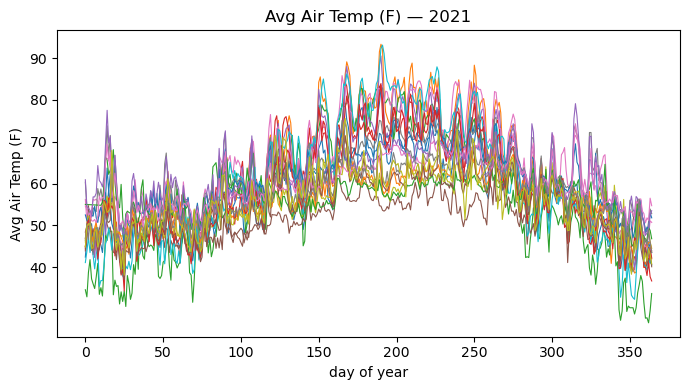

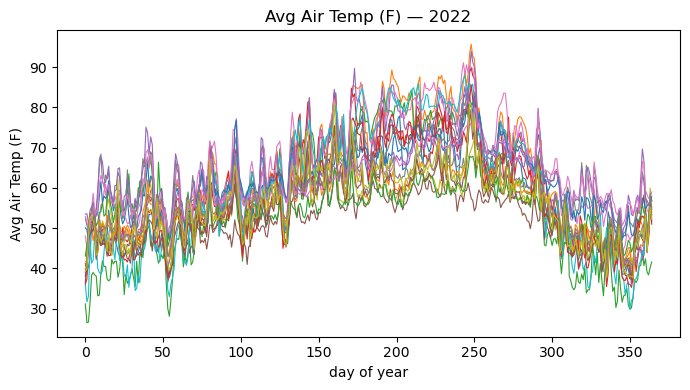

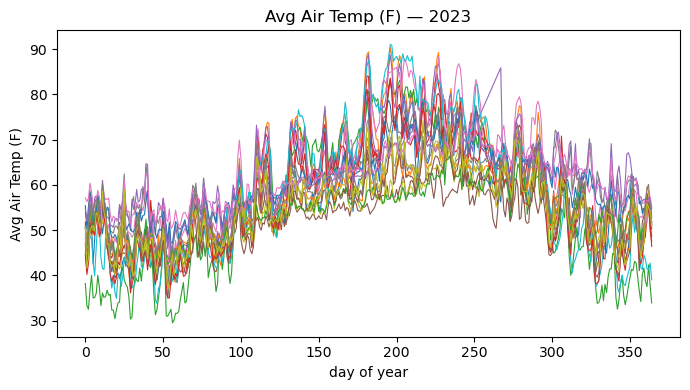

In [655]:
import numpy as np
import pandas as pd
from skfda import FDataGrid

# years = np.unique(pd.to_datetime(common_dates).year)
years = np.unique(common_dates.dt.year)
fds_by_year = {}

for y in years:
    # mask = (pd.to_datetime(common_dates).year == y)
    mask  = (common_dates.dt.year == y)

    # x-axis as day-of-year starting at 0
    t_doy = ((pd.to_datetime(common_dates)[mask] - pd.Timestamp(y, 1, 1))
             / pd.Timedelta(days=1)).to_numpy(dtype=float)

    # subset the data for this year
    dm_y = data_matrix[:, mask, :]  # (n_samples, n_points_in_year, 2)

    fds_by_year[y] = FDataGrid(
        data_matrix=dm_y,
        grid_points=[t_doy],
        argument_names=("day_of_year",),
        coordinate_names=("Precip (in)", "Avg Air Temp (F)")
    )

# Example: plot temperature for each year
# temp is coordinate 1 -> easiest is to grab the numpy and plot
import matplotlib.pyplot as plt

for y in years:
    plt.figure(figsize=(7,4))
    # all samples’ temperature in that year
    temp_y = fds_by_year[y].data_matrix[..., 1]  # shape: (n_samples, n_points_in_year)
    x = fds_by_year[y].grid_points[0]
    plt.plot(x, temp_y.T, linewidth=0.8)
    plt.title(f"Avg Air Temp (F) — {y}")
    plt.xlabel("day of year")
    plt.ylabel("Avg Air Temp (F)")
    plt.tight_layout()
    plt.show()

In [656]:
# print(type(fds_by_year))

In [657]:
import numpy as np
from skfda import FDataGrid

years = sorted(fds_by_year.keys())

# common 365-day grid: 0..364 (float)
common_grid = np.arange(365, dtype=float)

# Evaluate each yearly FDataGrid on the common grid (linear interpolation)
aligned_year_blocks = []
for y in years:
    fd_y = fds_by_year[y]                # FDataGrid of shape (n_samples, days_in_year, n_features)
    vals = fd_y(common_grid)             # -> (n_samples, 365, n_features)
    aligned_year_blocks.append(vals)

# Stack all years along the sample axis
data_matrix_all = np.concatenate(aligned_year_blocks, axis=0)  # (n_samples * n_years, 365, n_features)

# Build a single FDataGrid
fd_all_years = FDataGrid(
    data_matrix=data_matrix_all,
    grid_points=[common_grid],
    argument_names=("day_of_year",),
    coordinate_names=("Precip (in)", "Avg Air Temp (F)")
)

# print(fd_all_years)
print("Shape:", fd_all_years.data_matrix.shape)  # (samples*years, 365, 2)

Shape: (57, 365, 2)


In [658]:
# data = skfda.datasets.fetch_weather()
# fd = data['data']
fd = fd_all_years

# Split dataset, temperatures and curves of precipitation
X, y = fd.coordinates

Temperatures



In [659]:
# print(type(fd))

In [660]:
# print(len(fd.grid_points))
# print(len(fd.data_matrix[0]))

In [661]:
print(type(fd))                 # skfda.representation.grid.FDataGrid
print(fd.n_samples)
print(fd.dim_domain, fd.dim_codomain)
print(fd.domain_range)          # e.g., ((0.0, 365.0),)
print(len(fd.grid_points[0]))   # number of time points
print(fd.data_matrix.shape)     # raw tensor shape

<class 'skfda.representation.grid.FDataGrid'>
57
1 2
((0.0, 364.0),)
365
(57, 365, 2)


In [662]:
fd0 = fd[0]               # first curve (still an FDataGrid with 1 sample)
fd_first5 = fd[:5]        # first five curves
yvals_first = fd.data_matrix[0]          # numpy array of y on the grid
xgrid = fd.grid_points[0]                # numpy array of x grid

In [663]:
import numpy as np
fd_interp = fd        # FDataGrid supports evaluation with interpolation
new_x = np.array([10.0, 100.0, 200.0])   # domain units (e.g., day index)
vals = fd_interp(new_x)                  # shape: (n_samples, len(new_x), dim_codomain)

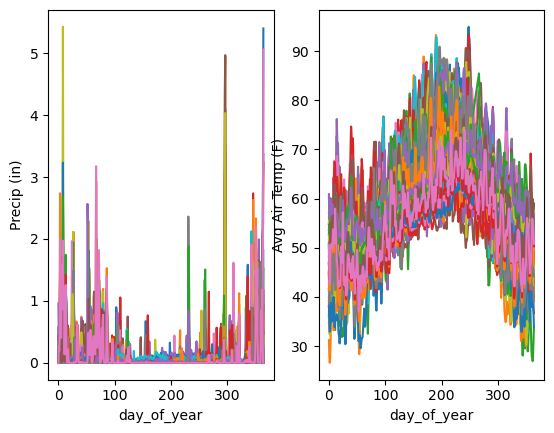

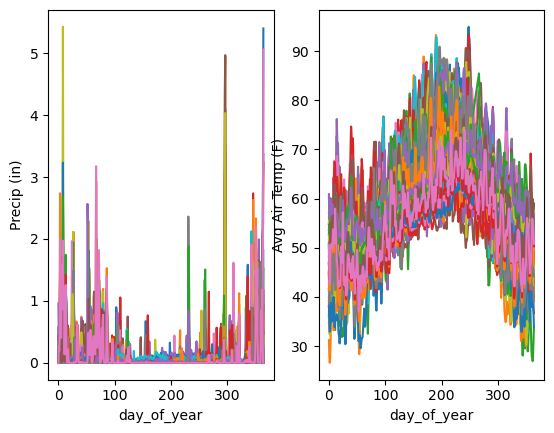

In [664]:
fd[:].plot()          # plot first 5 curves

In [665]:
# print("Data Matrix:", fd.data_matrix[0])
# print("Grid Points:", fd.grid_points)

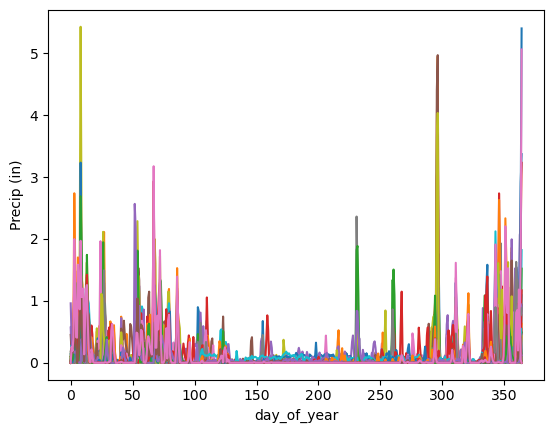

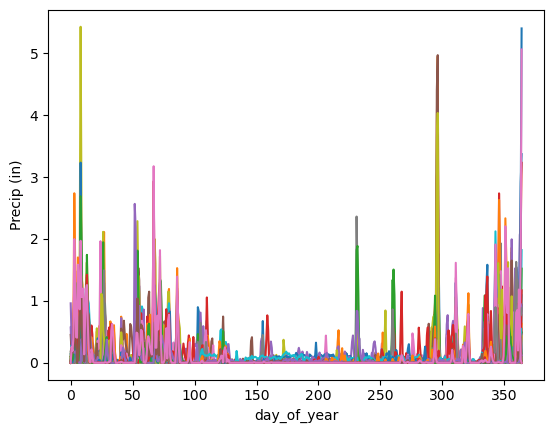

In [666]:
X.plot()

Precipitation



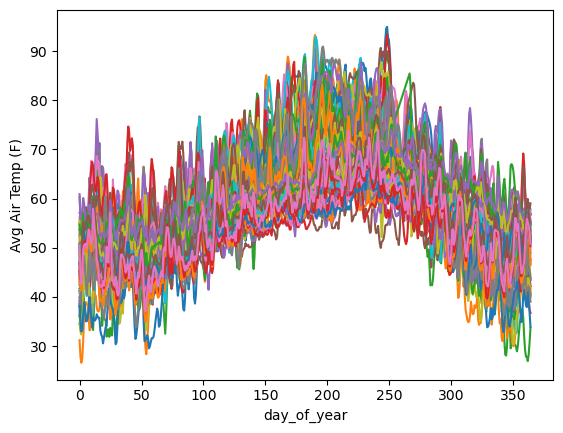

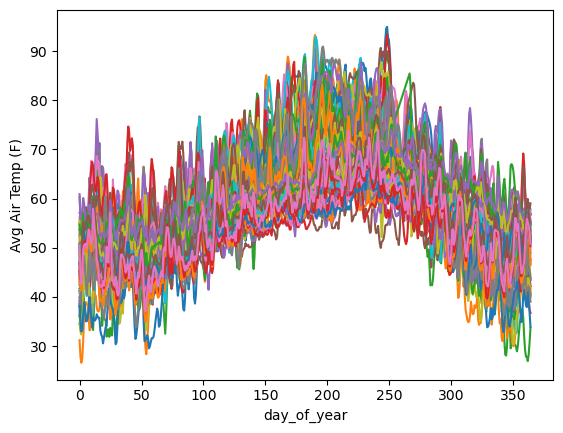

In [667]:
y.plot()

We will try to predict the precipitation curves. First of all we are going
to make a smoothing of the precipitation curves using a basis
representation, employing for it a fourier basis with 5 elements.



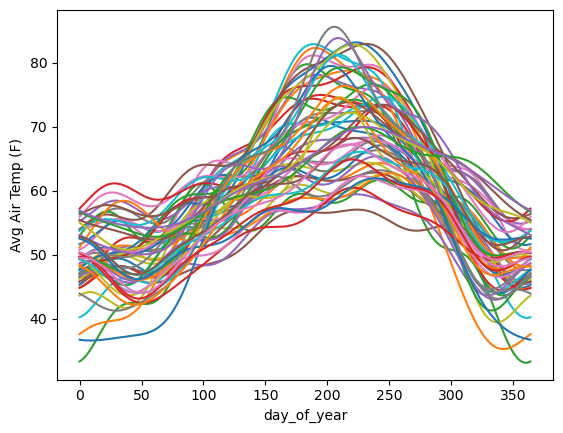

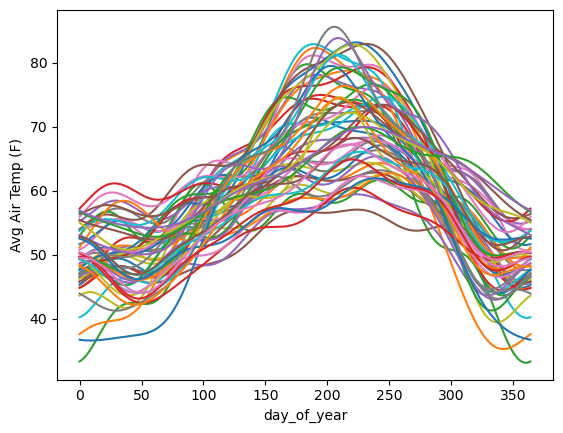

In [668]:
fourier_basis = 10

y = y.to_basis(FourierBasis(n_basis=fourier_basis))

y.plot()

In [669]:
# print(type(y))

In [670]:
import numpy as np
import pandas as pd

fd = y  # your FDataBasis

# 1) Choose an x-grid to evaluate on (use 365 points over the domain)
dom = fd.basis.domain_range[0]        # (start, end)
x = np.linspace(dom[0], dom[1], 365)  # adjust resolution if you like

# 2) Evaluate: shape -> (n_samples, n_points, dim_codomain)
vals = fd(x)

n_samples = vals.shape[0]
n_points  = vals.shape[1]
dim_co    = 1 if vals.ndim == 2 else vals.shape[2]

# 3a) Wide format: one column per sample (scalar codomain)
if dim_co == 1:
    df_wide = pd.DataFrame({"x": x})
    for i in range(n_samples):
        df_wide[f"sample_{i}"] = vals[i, :, 0] if vals.ndim == 3 else vals[i, :]
    df_wide.to_csv(f"y_f{fourier_basis}_vals_wide.csv", index=False)
    print(f"Saved y_f{fourier_basis}_vals_wide.csv")


Saved y_f10_vals_wide.csv


We will split the dataset in two partitions, for training and test,
using the sklearn function
:func:`~sklearn.model_selection.train_test_split`.



In [671]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=28,
)

We will try make a prediction using 5 neighbors and the $\mathbb{L}^2$
distance. In this case, to calculate
the response we will use a mean of the response, weighted by their distance
to the test sample.



In [672]:
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,metric,LpDistance(p=...tor_norm=None)
,n_jobs,None


We can predict values for the test partition using
:meth:`~skfda.ml.regression.KNeighborsFunctionalRegressor.predict`. The
following figure shows the real precipitation curves, in dashed line, and
the predicted ones.



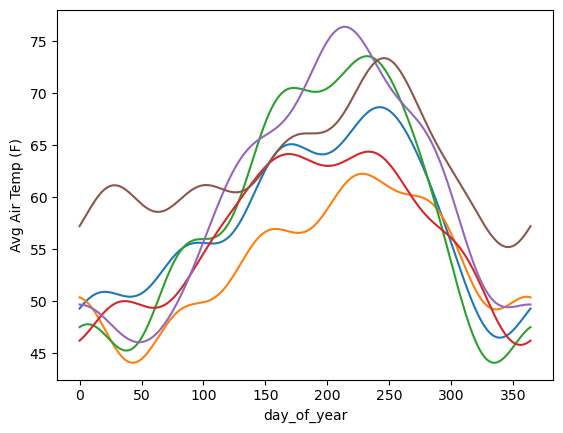

In [673]:
fig_a =y_test.plot()
fig_a.axes[0].set_prop_cycle(None)  # Reset colors


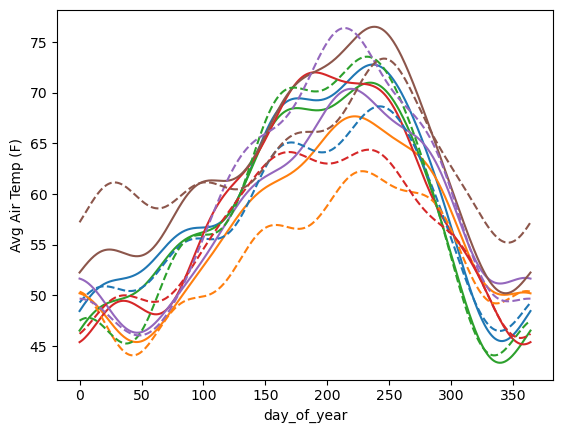

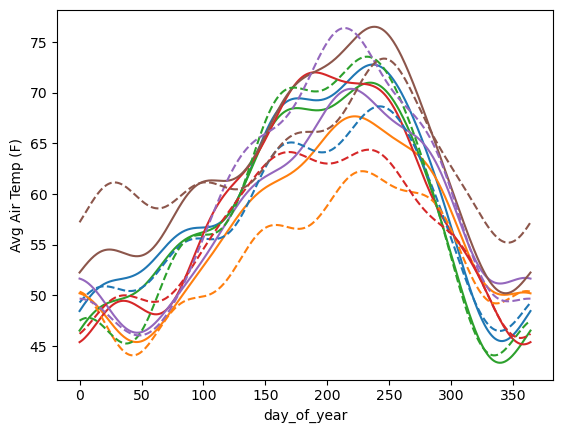

In [674]:
y_pred = knn.predict(X_test)

# Plot prediction
fig = y_pred.plot()
fig.axes[0].set_prop_cycle(None)  # Reset colors
y_test.plot(fig=fig, linestyle='--')


In [675]:
y_pred

FDataBasis(
    basis=FourierBasis(domain_range=((0.0, 364.0),), n_basis=11, period=364.0),
    coefficients=[[ 1.13731498e+03 -5.18829339e+01 -1.48720742e+02  4.36189861e+01
      -1.76179104e+01  2.54977690e+01  1.97354658e+00 -5.59485067e+00
       8.42320163e+00  1.10199075e+01  5.58401028e+00]
     [ 1.08206793e+03 -8.00477303e+01 -1.11728554e+02  3.15542135e+00
      -6.23354429e+00  4.83639655e+00  1.45109763e+01  7.37509416e+00
       6.23290120e+00  5.24003305e-01  9.47940458e+00]
     [ 1.10866440e+03 -4.10267102e+01 -1.58433768e+02  4.16003133e+01
      -1.74010403e+01  2.43015887e+01  4.96980991e+00 -5.14170322e+00
       8.80186054e+00  9.29076093e+00  5.93047057e+00]
     [ 1.11883150e+03 -6.09168917e+01 -1.64780263e+02  1.51072084e+01
       1.98116379e+00  1.04668394e+01  1.45756649e+00  6.94014523e+00
      -2.93518190e+00  6.15323916e+00 -1.44574700e+01]
     [ 1.10825183e+03 -8.64933231e+01 -1.17217888e+02  7.70417413e+00
      -3.02926433e+00  3.39358396e+00  1.5904

In [676]:
import numpy as np
import pandas as pd

fd = y_pred  # your FDataBasis

# 1) Choose an x-grid to evaluate on (use 365 points over the domain)
dom = fd.basis.domain_range[0]        # (start, end)
x = np.linspace(dom[0], dom[1], 365)  # adjust resolution if you like

# 2) Evaluate: shape -> (n_samples, n_points, dim_codomain)
vals = fd(x)

n_samples = vals.shape[0]
n_points  = vals.shape[1]
dim_co    = 1 if vals.ndim == 2 else vals.shape[2]

# 3a) Wide format: one column per sample (scalar codomain)
if dim_co == 1:
    df_wide = pd.DataFrame({"x": x})
    for i in range(n_samples):
        df_wide[f"sample_{i}"] = vals[i, :, 0] if vals.ndim == 3 else vals[i, :]
    df_wide.to_csv("y_predicted_vals_wide.csv", index=False)
    print("Saved y_predicted_vals_wide.csv")

# # 3b) Long/tidy format: works for scalar or vector codomain
# rows = []
# for i in range(n_samples):
#     if dim_co == 1:
#         rows.append(pd.DataFrame({
#             "sample": i,
#             "x": x,
#             "value": vals[i, :, 0] if vals.ndim == 3 else vals[i, :]
#         }))
#     else:
#         # multiple coordinates -> one row per coordinate
#         for c in range(dim_co):
#             rows.append(pd.DataFrame({
#                 "sample": i,
#                 "coord": c,
#                 "x": x,
#                 "value": vals[i, :, c]
#             }))
# df_long = pd.concat(rows, ignore_index=True)
# df_long.to_csv("fdatabasis_evaluated_long.csv", index=False)
# print("Saved fdatabasis_evaluated_long.csv")

Saved y_predicted_vals_wide.csv


In [677]:
import numpy as np
import pandas as pd

fd = y_test  # your FDataBasis

# 1) Choose an x-grid to evaluate on (use 365 points over the domain)
dom = fd.basis.domain_range[0]        # (start, end)
x = np.linspace(dom[0], dom[1], 365)  # adjust resolution if you like

# 2) Evaluate: shape -> (n_samples, n_points, dim_codomain)
vals = fd(x)

n_samples = vals.shape[0]
n_points  = vals.shape[1]
dim_co    = 1 if vals.ndim == 2 else vals.shape[2]

# 3a) Wide format: one column per sample (scalar codomain)
if dim_co == 1:
    df_wide = pd.DataFrame({"x": x})
    for i in range(n_samples):
        df_wide[f"sample_{i}"] = vals[i, :, 0] if vals.ndim == 3 else vals[i, :]
    df_wide.to_csv("y_test_vals_wide.csv", index=False)
    print("Saved y_test_vals_wide.csv")

# # 3b) Long/tidy format: works for scalar or vector codomain
# rows = []
# for i in range(n_samples):
#     if dim_co == 1:
#         rows.append(pd.DataFrame({
#             "sample": i,
#             "x": x,
#             "value": vals[i, :, 0] if vals.ndim == 3 else vals[i, :]
#         }))
#     else:
#         # multiple coordinates -> one row per coordinate
#         for c in range(dim_co):
#             rows.append(pd.DataFrame({
#                 "sample": i,
#                 "coord": c,
#                 "x": x,
#                 "value": vals[i, :, c]
#             }))
# df_long = pd.concat(rows, ignore_index=True)
# df_long.to_csv("fdatabasis_evaluated_long.csv", index=False)
# print("Saved fdatabasis_evaluated_long.csv")

Saved y_test_vals_wide.csv


In [678]:
df_wide.shape

(365, 7)